In [1]:
%cd python

C:\Users\kisha\Documents\LRP_Demo\python


# Notebook to play around the different threshold, digits and methods

In [2]:
import matplotlib.pyplot as plt
import time
import numpy
import numpy as np
import importlib.util as imp
if imp.find_spec("cupy"): #use cupy for GPU support if available
    import cupy
    import cupy as np
na = np.newaxis

import model_io
import data_io
import render
# import cv2

In [3]:
#load a neural network, as well as the MNIST test data and some labels
nn = model_io.read('../mnist_mlp-Base.txt') # 99.16% prediction accuracy
nn.drop_softmax_output_layer() #drop softnax output layer for analyses

loading plain text model from ../mnist_mlp-Base.txt
removing softmax output mapping


In [4]:
nn_target = model_io.read('../mnist_mlp-Target.txt') # 99.16% prediction accuracy
nn_target.drop_softmax_output_layer() #drop softnax output layer for analyses

loading plain text model from ../mnist_mlp-Target.txt
removing softmax output mapping


In [5]:
Xtest_full = data_io.read('../data/MNIST/test_images.npy')
Ytest_full = data_io.read('../data/MNIST/test_labels.npy')

loading np-formatted data from ../data/MNIST/test_images.npy
loading np-formatted data from ../data/MNIST/test_labels.npy


In [6]:
Xtest = []
Ytest = []

for i in range(len(Ytest_full)):
    if Ytest_full[i] in [[5], [6], [7], [8], [9]]:
        Ytest.append(Ytest_full[i])
        Xtest.append(Xtest_full[i])

X = np.array(Xtest)
Y = np.array(Ytest)

In [7]:
# transfer pixel values from [0 255] to [-1 1] to satisfy the expected input / training paradigm of the model
X =  X / 127.5 - 1

In [8]:
# transform numeric class labels to vector indicator for uniformity. assume presence of all classes within the label set
I = Y[:,0].astype(int) - 5
Y = np.zeros([X.shape[0],np.unique(Y).size])
Y[np.arange(Y.shape[0]),I] = 1

In [9]:
acc = np.mean(np.argmax(nn.forward(X), axis=1) == np.argmax(Y, axis=1))
if not np == numpy: # np=cupy
    acc = np.asnumpy(acc)
print('model test accuracy is: {:0.4f}'.format(acc))

model test accuracy is: 0.3868


In [10]:
#permute data order for demonstration. or not. your choice.
I = np.arange(X.shape[0])
#I = np.random.permutation(I)

In [11]:
#Select a Digit between 5-9
digit = 8
for i in I:
  if np.argmax(Y[i])+5 == digit:
    break


True label:      8
Predicted label: 2 

Prediction Score 0-4 [[-2.86213535 -2.72662566 11.48276308  0.11510645 -2.5369613 ]]
784


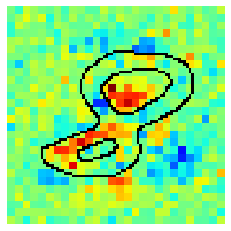

In [18]:
#Find Relevance using Base network

x = X[na,i,:]

#forward pass and prediction
ypred = nn.forward(x)
print('True label:     ', np.argmax(Y[i])+5)
print('Predicted label:', np.argmax(ypred),'\n')
print('Prediction Score 0-4', ypred)

#prepare initial relevance to reflect the model's dominant prediction (ie depopulate non-dominant output neurons)
mask = np.zeros_like(ypred)
mask[:,np.argmax(ypred)] = 1
Rinit = ypred*mask

#compute first layer relevance according to prediction
#R = nn.lrp(Rinit)                   #as Eq(56) from DOI: 10.1371/journal.pone.0130140
R = nn.lrp(Rinit,'simple', 2, reset=0)    #as Eq(58) from DOI: 10.1371/journal.pone.0130140
#R = nn.lrp(Rinit,'alphabeta',2)    #as Eq(60) from DOI: 10.1371/journal.pone.0130140


#R = nn.lrp(ypred*Y[na,i]) #compute first layer relevance according to the true class label
'''
yselect = 3
yselect = (np.arange(Y.shape[1])[na,:] == yselect)*1.
R = nn.lrp(ypred*yselect) #compute first layer relvance for an arbitrarily selected class
'''

#undo input normalization for digit drawing. get it back to range [0,1] per pixel
x = (x+1.)/2.

if not np == numpy: # np=cupy
    x = np.asnumpy(x)
    R = np.asnumpy(R)

print(len(R[0]))
#render input and heatmap as rgb images
digit = render.digit_to_rgb(x, scaling = 3)
hm = render.hm_to_rgb(R, X = x, scaling = 3, sigma = 2)
#digit_hm = render.save_image([digit,hm],'../heatmap_base'+str(i)+'.png')
# data_io.write(R,'../Base/heatmap_base'+str(i)+'.npy')

#display the image as written to file
plt.imshow(hm, interpolation = 'none')
plt.axis('off')
plt.show()

True label:      8
Predicted label: 8 

Prediction Score 5-9 [[ 0.73498147 -1.67062127  0.57766795  4.00967128 -2.0907259 ]]
Here is, lrp
(array([   0,    2,   13,   16,   21,   27,   31,   38,   51,   55,   58,
         62,   65,   69,   76,   87,   89,   91,   99,  104,  118,  120,
        130,  135,  140,  142,  143,  146,  159,  170,  174,  176,  183,
        189,  190,  192,  199,  201,  202,  207,  208,  240,  249,  254,
        258,  270,  279,  283,  289,  299,  308,  318,  337,  341,  345,
        362,  372,  382,  384,  392,  398,  399,  415,  420,  428,  429,
        434,  439,  441,  457,  458,  471,  472,  476,  486,  493,  500,
        501,  503,  505,  510,  526,  531,  533,  540,  545,  546,  550,
        551,  553,  560,  579,  588,  601,  618,  619,  620,  628,  646,
        647,  661,  662,  665,  666,  669,  677,  679,  680,  683,  687,
        688,  690,  692,  694,  728,  736,  741,  742,  755,  764,  767,
        771,  772,  781,  791,  792,  794,  795,  798,  82

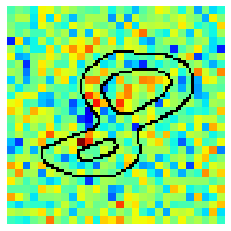

In [20]:
#Find Relevance using Target network

x = X[na,i,:]

#forward pass and prediction
ypred = nn_target.forward(x)
print('True label:     ', np.argmax(Y[i])+5)
print('Predicted label:', np.argmax(ypred)+5,'\n')
print('Prediction Score 5-9', ypred)

#prepare initial relevance to reflect the model's dominant prediction (ie depopulate non-dominant output neurons)
mask = np.zeros_like(ypred)
mask[:,np.argmax(ypred)] = 1
Rinit = ypred*mask

#compute first layer relevance according to prediction
#R = nn.lrp(Rinit)                   #as Eq(56) from DOI: 10.1371/journal.pone.0130140
R_target = nn_target.lrp(Rinit,'simple', 2, reset=2)    #as Eq(58) from DOI: 10.1371/journal.pone.0130140
#R = nn.lrp(Rinit,'alphabeta',2)    #as Eq(60) from DOI: 10.1371/journal.pone.0130140
print(R_target)
print(max(R_target), min(R_target))

#R = nn.lrp(ypred*Y[na,i]) #compute first layer relevance according to the true class label
'''
yselect = 3
yselect = (np.arange(Y.shape[1])[na,:] == yselect)*1.
R = nn.lrp(ypred*yselect) #compute first layer relvance for an arbitrarily selected class
'''

#undo input normalization for digit drawing. get it back to range [0,1] per pixel
x = (x+1.)/2.

if not np == numpy: # np=cupy
    x = np.asnumpy(x)
    R_target = np.asnumpy(R)


#render input and heatmap as rgb images
digit = render.digit_to_rgb(x, scaling = 3)
hm_target = render.hm_to_rgb(R_target, X = x, scaling = 3, sigma = 2)
#digit_hm = render.save_image([digit,hm],'../heatmap_base'+str(i)+'.png')
# data_io.write(R,'../Base/heatmap_base'+str(i)+'.npy')

#display the image as written to file
plt.imshow(hm_target, interpolation = 'none')
plt.axis('off')
plt.show()

In [14]:
R = R[0]
R_target = R_target[0]

78
Common red pixels 4
78
78
Common blue pixels 6


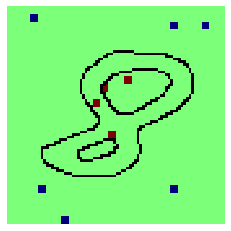

In [15]:
# Overlap Image
# r, g, b = cv2.split(hm)
# r2, g2, b2 = cv2.split(hm_target)

# t = 0.7

# threshold1 = max(R) * t
# threshold2 = max(R_target) * t


# #Dynamic threshold
# tmp = np.where(R > 0.1)
# threshold1 = np.mean(R[tmp])

# tmp = np.where(R_target > 0.1)
# threshold2 = np.mean(R_target[tmp])

#Top how many percent
t = 10
target = int(784 - 7.84*t)
threshold1 = np.partition(R, target)[target]
threshold2 = np.partition(R_target, target)[target]

indices1 = np.where(R > threshold1)
print(len(indices1[0]))
# print(indices1)

indices2 = np.where(R_target > threshold2)
# print(len(indices2))

common_red = np.intersect1d(indices1, indices2)
print("Common red pixels", len(common_red))
# print(common_red)
R_overlap = np.zeros(784)
R_overlap[common_red] = 10 


target = int(7.84*t)
threshold1 = np.partition(R, target)[target]
threshold2 = np.partition(R_target, target)[target]

indices1 = np.where(R < threshold1)
print(len(indices1[0]))

indices2 = np.where(R_target < threshold2)
print(len(indices2[0]))

common_blue = np.intersect1d(indices1, indices2)
print("Common blue pixels", len(common_blue))

R_overlap[common_blue] = -10 


hm_overlap = render.hm_to_rgb(R_overlap, X = x, scaling = 3, sigma = 2)
#digit_hm = render.save_image([digit,hm],'../heatmap_base'+str(i)+'.png')
# data_io.write(R,'../Base/heatmap_base'+str(i)+'.npy')

#display the image as written to file
plt.imshow(hm_overlap, interpolation = 'none')
plt.axis('off')
plt.show()

# plt.imshow(r2, interpolation = 'none')
# plt.axis('off')
# plt.show()


In [16]:
nn_target.modules[7].W[0]

array([ 0.02758565,  0.02051535, -0.03984159, ..., -0.02904586,
       -0.01522147, -0.03359845])